In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import pickle
import ast
from ast import literal_eval

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression

# Movie model

The movie model is to predict revenue from other movies' data.

In [120]:
movie = pd.read_csv("prepocessed_movies_metadata.csv",converters={"genres_name": literal_eval, "production_countries": literal_eval, "genres_id": literal_eval})

In [121]:
movie = movie.rename(columns={"id": "movieId"})

In [122]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36554 entries, 0 to 36553
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                36554 non-null  float64
 1   movieId               36554 non-null  int64  
 2   production_countries  36554 non-null  object 
 3   original_language     36554 non-null  object 
 4   original_title        36554 non-null  object 
 5   popularity            36554 non-null  float64
 6   revenue               36554 non-null  float64
 7   runtime               36554 non-null  float64
 8   vote_average          36554 non-null  float64
 9   vote_count            36554 non-null  float64
 10  genres_name           36554 non-null  object 
 11  genres_id             36554 non-null  object 
 12  release_year          36554 non-null  int64  
dtypes: float64(6), int64(2), object(5)
memory usage: 3.6+ MB


In [99]:
movie_with_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38319 entries, 0 to 38318
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                8564 non-null   float64
 1   movieId               38319 non-null  int64  
 2   production_countries  38319 non-null  object 
 3   original_language     38311 non-null  object 
 4   original_title        38319 non-null  object 
 5   popularity            38319 non-null  float64
 6   revenue               7242 non-null   float64
 7   runtime               38193 non-null  float64
 8   vote_average          36644 non-null  float64
 9   vote_count            38319 non-null  float64
 10  genres_name           38319 non-null  object 
 11  genres_id             38319 non-null  object 
 12  release_year          38319 non-null  int64  
dtypes: float64(6), int64(2), object(5)
memory usage: 3.8+ MB


In [100]:
user.head()

,userId,movieId,rating,timestamp,Gender,Age,Occupation,Zip-code
0,1,110,1.0,1425941529,F,1,10,48067
1,1,147,4.5,1425942435,F,1,10,48067
2,1,858,5.0,1425941523,F,1,10,48067
3,1,1221,5.0,1425941546,F,1,10,48067
4,1,1246,5.0,1425941556,F,1,10,48067


columns_to_dummy function is to transfrom categorical data to numerical data, actually one-hot is used instead of dummy, because there are multiple genre and production_country, one-hot is more suiltable in this case.

In [5]:
def columns_to_dummy(columns, df):
    final_df = df.copy()
    for column in columns:
        print(column)
        df_column_dummy = pd.Series(df[column])
        df_column_dummy = pd.get_dummies(df_column_dummy.apply(pd.Series).stack()).sum(level=0)
        final_df = pd.concat([final_df, df_column_dummy], axis=1)
    final_df.drop(labels=columns, axis=1, inplace=True)
    return final_df

In [102]:
movie_dummy = columns_to_dummy(["original_language", "production_countries", "genres_name"], movie)

original_language
production_countries
genres_name


In [105]:
movie_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36554 entries, 0 to 36553
Columns: 269 entries, budget to Western
dtypes: float64(6), int64(2), object(2), uint8(259)
memory usage: 11.8+ MB


This is the correlation map between numerical data and we can see that vote_count and budget have high correlation with revenue.

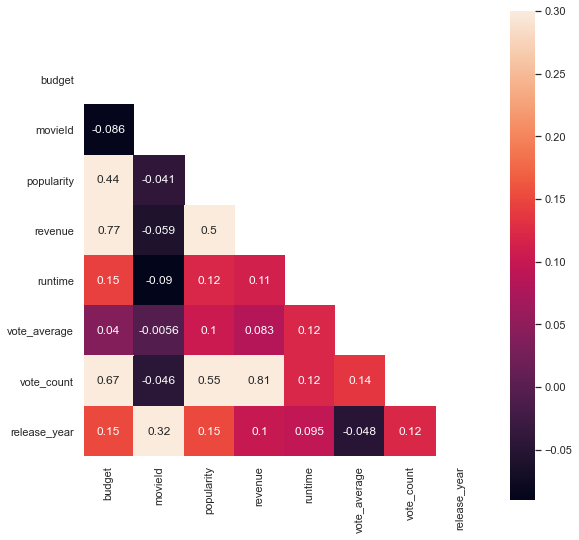

In [107]:
sns.set(font_scale=1)
corr = movie.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(9,9))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

In [131]:
movie_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36554 entries, 0 to 36553
Columns: 269 entries, budget to Western
dtypes: float64(6), int64(2), object(2), uint8(259)
memory usage: 11.8+ MB


In [124]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X, y = imputer.fit_transform(movie_dummy[["budget", "vote_count"]]), movie_dummy['revenue']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.7469


In [125]:
columns = movie_dummy.columns.to_list()

In [126]:
columns.remove("original_title")

In [127]:
columns.remove("genres_id")

In [128]:
columns.remove("revenue")

In [129]:
X, y = movie_dummy[columns], movie_dummy['revenue']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.7544


The result is acceptable and we can see that there is little improvement if we use all variables instead of only use budget and vote_count.

In [155]:
movie_dummy[["budget", "revenue"]].value_counts()

budget       revenue     
0.0          0.000000e+00    26146
2000000.0    0.000000e+00      141
5000000.0    0.000000e+00      139
3000000.0    0.000000e+00      116
1000000.0    0.000000e+00      113
                             ...  
1300000.0    2.913300e+07        1
             2.826257e+07        1
             1.600000e+07        1
             1.075000e+07        1
380000000.0  1.045714e+09        1
Length: 7834, dtype: int64

There are so many pair of 0 in budget and revenue, we try to filter those data and build model on it after filtering.

In [140]:
movie_dummy_filted = movie_dummy[movie_dummy['revenue'] >= 1000]
movie_dummy_filted = movie_dummy_filted[movie_dummy_filted['budget'] >= 1000]
movie_dummy_filted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5248 entries, 0 to 36524
Columns: 269 entries, budget to Western
dtypes: float64(6), int64(2), object(2), uint8(259)
memory usage: 1.7+ MB


In [142]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X, y = imputer.fit_transform(movie_dummy_filted[["budget", "vote_count"]]), movie_dummy_filted['revenue']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.7103


In [143]:
columns = movie_dummy_filted.columns.to_list()

In [144]:
columns.remove("original_title")

In [145]:
columns.remove("genres_id")

In [146]:
columns.remove("revenue")

In [148]:
X, y = movie_dummy_filted[columns], movie_dummy_filted['revenue']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.7382


The performance of model droped a little bit, but the model should by more general as filtering pair of 0 in budget and revenue.

# User model

In [2]:
user = pd.read_csv("rating_with_user_metadata.csv")

In [3]:
user

,userId,movieId,rating,timestamp,Gender,Age,Occupation,Zip-code
0,1,110,1.0,1425941529,F,1,10,48067
1,1,147,4.5,1425942435,F,1,10,48067
2,1,858,5.0,1425941523,F,1,10,48067
3,1,1221,5.0,1425941546,F,1,10,48067
4,1,1246,5.0,1425941556,F,1,10,48067
...,...,...,...,...,...,...,...,...
597819,6040,2890,3.0,1169782765,M,25,6,11106
597820,6040,2947,3.5,1169782899,M,25,6,11106
597821,6040,3994,4.0,1169782755,M,25,6,11106
597822,6040,7361,4.5,1169782828,M,25,6,11106


In [6]:
user_dummy = columns_to_dummy(["Gender", "Zip-code"], user)

Gender
Zip-code


In [7]:
user_dummy.Age.unique()

array([ 1, 56, 25, 45, 50, 35, 18])

In [8]:
columns = user_dummy.columns.to_list()

In [9]:
columns.remove("rating")

In [10]:
X, y = user_dummy[columns], user_dummy['rating']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.1333


The result of model is not good, so we would like to use rating of other movies to predict.

In [12]:
movieId_list = user.movieId.unique()
userId_list = user.userId.unique()

In [13]:
columns = ["userId"]+list(movieId_list)

In [14]:
df = pd.DataFrame({"userId" : userId_list})

In [15]:
for movieId in list(movieId_list):
    df[movieId] = np.nan

In [17]:
rating_list = user_dummy[["userId", "movieId", "rating"]].to_dict('records')

In [18]:
df.head()

,userId,110,147,858,1221,1246,1968,2762,2918,2959,...,129358,139128,153236,55854,60894,114182,5322,144636,1138,2503
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
rating_list

[{'userId': 1, 'movieId': 110, 'rating': 1.0},
 {'userId': 1, 'movieId': 147, 'rating': 4.5},
 {'userId': 1, 'movieId': 858, 'rating': 5.0},
 {'userId': 1, 'movieId': 1221, 'rating': 5.0},
 {'userId': 1, 'movieId': 1246, 'rating': 5.0},
 {'userId': 1, 'movieId': 1968, 'rating': 4.0},
 {'userId': 1, 'movieId': 2762, 'rating': 4.5},
 {'userId': 1, 'movieId': 2918, 'rating': 5.0},
 {'userId': 1, 'movieId': 2959, 'rating': 4.0},
 {'userId': 1, 'movieId': 4226, 'rating': 4.0},
 {'userId': 1, 'movieId': 4878, 'rating': 5.0},
 {'userId': 1, 'movieId': 5577, 'rating': 5.0},
 {'userId': 1, 'movieId': 33794, 'rating': 4.0},
 {'userId': 1, 'movieId': 54503, 'rating': 3.5},
 {'userId': 1, 'movieId': 58559, 'rating': 4.0},
 {'userId': 1, 'movieId': 59315, 'rating': 5.0},
 {'userId': 1, 'movieId': 68358, 'rating': 5.0},
 {'userId': 1, 'movieId': 69844, 'rating': 5.0},
 {'userId': 1, 'movieId': 73017, 'rating': 5.0},
 {'userId': 1, 'movieId': 81834, 'rating': 5.0},
 {'userId': 1, 'movieId': 91500, 'r

In [20]:
for rating in rating_list:
    df.loc[df['userId'] == rating["userId"], [rating["movieId"]]] = rating['rating']

In [21]:
df

,userId,110,147,858,1221,1246,1968,2762,2918,2959,...,129358,139128,153236,55854,60894,114182,5322,144636,1138,2503
0,1,1.0,4.5,5.0,5.0,5.0,4.0,4.5,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,4.0,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,6036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6036,6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,6039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
user_dummy.movieId.value_counts()

318       2171
356       2108
296       2048
593       1936
2571      1804
          ... 
94041        1
6309         1
151357       1
55485        1
170671       1
Name: movieId, Length: 16707, dtype: int64

In [24]:
df[318].value_counts()

5.0    1087
4.0     485
4.5     308
3.0     136
3.5      97
2.0      15
2.5      13
1.0      12
0.5      12
1.5       6
Name: 318, dtype: int64

In [25]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df_drop = df.dropna(subset=[318])
columns = df_drop.columns.to_list()
columns.remove(318)
X, y = imputer.fit_transform(df_drop[columns]), df_drop[318]
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.9801


In [26]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df_drop = df.dropna(subset=[356])
columns = df_drop.columns.to_list()
columns.remove(356)
X, y = imputer.fit_transform(df_drop[columns]), df_drop[356]
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.9737


In [27]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df_drop = df.dropna(subset=[296])
columns = df_drop.columns.to_list()
columns.remove(296)
X, y = imputer.fit_transform(df_drop[columns]), df_drop[296]
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.9570


The results are good, so other movie's ratings could be used to predict movie's rating.